<p style="background-color:White;color:Black;font-size:180%;"><u><i>Text generation using Cornell movie dialogs corpus</i></u></p>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import plotly.express as px
from collections import Counter
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tqdm import tqdm
import spacy
import nltk
import markovify

<p style="color:Green;font-size:150%;">1. Data preparation</p>

<p style="background-color:DodgerBlue;color:White;font-size:140%;">1.1 Install the convokit and download the corpus</p>

In [50]:
!pip install convokit
from convokit import Corpus, download
corpus = Corpus(filename=download("movie-corpus"))

<p style="font-size:120%;"> 1.11 Utterances dataframe</p>

In [20]:

df=corpus.get_utterances_dataframe()
df

,timestamp,text,speaker,reply_to,conversation_id,meta.movie_id,meta.parsed,vectors
id,,,,,,,,
L1045,None,They do not!,u0,L1044,L1044,m0,"[{'rt': 1, 'toks': [{'tok': 'They', 'tag': 'PR...",[]
L1044,None,They do to!,u2,None,L1044,m0,"[{'rt': 1, 'toks': [{'tok': 'They', 'tag': 'PR...",[]
L985,None,I hope so.,u0,L984,L984,m0,"[{'rt': 1, 'toks': [{'tok': 'I', 'tag': 'PRP',...",[]
L984,None,She okay?,u2,None,L984,m0,"[{'rt': 1, 'toks': [{'tok': 'She', 'tag': 'PRP...",[]
L925,None,Let's go.,u0,L924,L924,m0,"[{'rt': 0, 'toks': [{'tok': 'Let', 'tag': 'VB'...",[]
...,...,...,...,...,...,...,...,...
L666371,None,Lord Chelmsford seems to want me to stay back ...,u9030,L666370,L666369,m616,"[{'rt': 2, 'toks': [{'tok': 'Lord', 'tag': 'NN...",[]
L666370,None,I'm to take the Sikali with the main column to...,u9034,L666369,L666369,m616,"[{'rt': 1, 'toks': [{'tok': 'I', 'tag': 'PRP',...",[]
L666369,None,"Your orders, Mr Vereker?",u9030,None,L666369,m616,"[{'rt': 1, 'toks': [{'tok': 'Your', 'tag': 'PR...",[]


<p style="font-size:120%;"> 1.12 Speakers dataframe</p>

In [21]:
corpus.get_speakers_dataframe()

,vectors,meta.character_name,meta.movie_idx,meta.movie_name,meta.gender,meta.credit_pos
id,,,,,,
u0,[],BIANCA,m0,10 things i hate about you,f,4
u2,[],CAMERON,m0,10 things i hate about you,m,3
u3,[],CHASTITY,m0,10 things i hate about you,?,?
u4,[],JOEY,m0,10 things i hate about you,m,6
u5,[],KAT,m0,10 things i hate about you,f,2
...,...,...,...,...,...,...
u9029,[],CREALOCK,m616,zulu dawn,?,?
u9033,[],STUART SMITH,m616,zulu dawn,?,?
u9028,[],COGHILL,m616,zulu dawn,?,?


<p style="font-size:120%;"> 1.13 conversations dataframe</p>

In [22]:
corpus.get_conversations_dataframe()

,vectors,meta.movie_idx,meta.movie_name,meta.release_year,meta.rating,meta.votes,meta.genre
id,,,,,,,
L1044,[],m0,10 things i hate about you,1999,6.90,62847,"['comedy', 'romance']"
L984,[],m0,10 things i hate about you,1999,6.90,62847,"['comedy', 'romance']"
L924,[],m0,10 things i hate about you,1999,6.90,62847,"['comedy', 'romance']"
L870,[],m0,10 things i hate about you,1999,6.90,62847,"['comedy', 'romance']"
L866,[],m0,10 things i hate about you,1999,6.90,62847,"['comedy', 'romance']"
...,...,...,...,...,...,...,...
L666324,[],m616,zulu dawn,1979,6.40,1911,"['action', 'adventure', 'drama', 'history', 'w..."
L666262,[],m616,zulu dawn,1979,6.40,1911,"['action', 'adventure', 'drama', 'history', 'w..."
L666520,[],m616,zulu dawn,1979,6.40,1911,"['action', 'adventure', 'drama', 'history', 'w..."


<p style="color:Green;font-size:150%;">2. 
Exploratory data analysis (EDA)</p>

<p style="background-color:DodgerBlue;color:White;font-size:140%;">2.1 Text length analysis</p> 



Text(0.5, 1.0, 'Word count anlaysis')

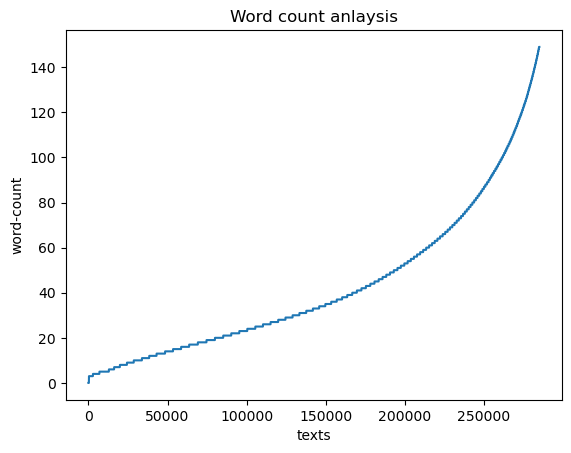

In [23]:
'''Plot of texts vs word count'''
a=(df['text'].apply(lambda x:len(x)))
textLength=sorted(list(a))
textLength=[i for i in textLength if i <150]
ind=[i for i in range(len(textLength))]
cdf=pd.DataFrame.from_dict({'text_count':ind,'textLength':textLength})
plt.plot(ind,textLength)
plt.xlabel('texts')
plt.ylabel('word-count')
plt.title('Word count anlaysis')


From the line plot of the text length,

* Nearly 50% of texts are formed by text with word counts<30 words.
* Nearly 80% of texts are formed by text with word counts<60 words

We have a considerably large number of lengthy texts available in our corpus.


<p style="background-color:DodgerBlue;color:White;font-size:140%;">2.2 Word cloud analysis</p> 

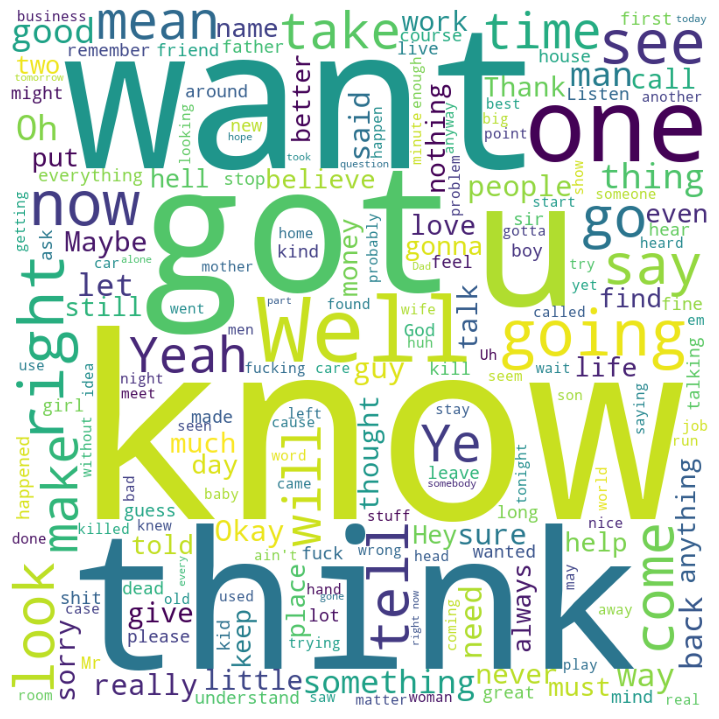

In [24]:
'''Word cloud'''
text=list(df['text'])
cloudWords = " ".join(text)
wordCloud=WordCloud(width=800,height=800,background_color="white",min_font_size=10).generate(cloudWords)
plt.figure(figsize=(7,7),facecolor=None)
plt.imshow(wordCloud)
plt.axis("off")
plt.tight_layout(pad=0)

From the word cloud,

* The words know,think and want are most occuring words in the corpus

* The words well,got,one and going are next most occuring words in the corpus.

Most of the words are typical words that are used in normal conversations.



<p style="background-color:DodgerBlue;color:White;font-size:140%;">2.3 Conversation length analysis</p> 

In [25]:
'''Plot of conversation length'''
conv_length=Counter(list(df['conversation_id']))
ind=[i for i in range(len(conv_length.keys()))]
converstation_length=sorted(conv_length.values())
cdf=pd.DataFrame.from_dict({'conversation_count':ind,'conversation_length':converstation_length})

fig=px.scatter(cdf,x='conversation_count',y='conversation_length',
           title='conversation_length Anlysis')
fig.update_yaxes(matches=None)
fig.show()

From the linechart of the conversations length,

* Nearly half of the conversations in the corpus have length 2.

* Nearly 7% of the conversation has a length of 4.

* Almost 90% of conversations have length less than 8.

Most of the conversation in the corpus have short duration only very few are of long duration


<p style="color:Green;font-size:150%;">3. 
Data preprocessing</p>

In [51]:
'''Create 2 columns from utterances_dataframe using text data for input and
label also a reference array to find BLEU score'''

df=corpus.get_utterances_dataframe()
df=df[['conversation_id','text']]
df=df[:100000]
ref=list(df.text.apply(lambda x:x.split()))

In [4]:
'''Create new columns for decoder_ouput,decoder_input and append start and 
end tokens to decoder data'''


df['encoder_input']=df.groupby(['conversation_id'])['text'].shift(1)
df=df.dropna()
df=df[['encoder_input','text']]


df.rename(columns={'text':'decoder_input'},inplace=True)
df['decoder_output']=df['decoder_input']

df['decoder_input']='<start> '+df['decoder_input']
df['decoder_output']=df['decoder_output']+' <end>'
df['decoder_input'].iloc[0]=df['decoder_input'].iloc[0]+' <end>'
df

,encoder_input,decoder_input,decoder_output
id,,,
L1044,They do not!,<start> They do to! <end>,They do to! <end>
L984,I hope so.,<start> She okay?,She okay? <end>
L924,Let's go.,<start> Wow,Wow <end>
L871,Okay -- you're gonna need to learn how to lie.,<start> No,No <end>
L870,No,<start> I'm kidding. You know how sometimes y...,I'm kidding. You know how sometimes you just ...
...,...,...,...
L536608,Then you must spend your life answering questi...,<start> I don't like to leave questions unansw...,I don't like to leave questions unanswered. <end>
L536607,I don't like to leave questions unanswered.,<start> Why?,Why? <end>
L536606,Why?,<start> I understand how you feel. We just wan...,I understand how you feel. We just want to ret...


In [5]:
import gc
train=df
del df
gc.collect()

23

In [6]:
'''Build tokenizer with encoder_input and decoder_input train set'''
encoder_input_tokenizer=tf.keras.preprocessing.text.Tokenizer(filters='!"#$()*+/:;=@[\\]^_`{|}~\t\n',
                                          lower=False,
                                          )
encoder_input_tokenizer.fit_on_texts(train['encoder_input'].values)
decoder_input_tokenizer=tf.keras.preprocessing.text.Tokenizer(filters='!"#$%()*+/:;=@[\\]^_`{|}~\t\n',
                                          lower=False,
                                          )
decoder_input_tokenizer.fit_on_texts(train['decoder_input'].values)

In [7]:
'''vocab lengths of encoder_input and decoder_input tokens '''
encoder_inlen=len(encoder_input_tokenizer.word_index.keys())
decoder_inlen=len(decoder_input_tokenizer.word_index.keys())
len(encoder_input_tokenizer.word_index.keys()),len(decoder_input_tokenizer.word_index.keys())

(58466, 57979)

In [18]:
'''<start> and <end> words integer equilent token'''
decoder_input_tokenizer.word_index['<end>'],decoder_input_tokenizer.word_index['<start>'],


(24640, 1)

In [8]:
'''Tokenize and pad the input and output text'''
max_input_len=105
max_sentencelen=22
enocoder_input_tokenized_train=encoder_input_tokenizer.texts_to_sequences(train['encoder_input'].values)
decoder_input_tokenized_train=decoder_input_tokenizer.texts_to_sequences(train['decoder_input'].values)
decoder_output_tokenized_train=decoder_input_tokenizer.texts_to_sequences(train['decoder_output'].values)

enocoder_input_padded_train=tf.keras.preprocessing.sequence.pad_sequences(enocoder_input_tokenized_train,
                                                                        maxlen=max_input_len
                                                                        ,truncating='post',
                                                                        padding='post',)
decoder_input_padded_train=tf.keras.preprocessing.sequence.pad_sequences(decoder_input_tokenized_train,
                                                                maxlen=max_sentencelen
                                                                ,truncating='post',
                                                                padding='post')
decoder_output_padded_train=tf.keras.preprocessing.sequence.pad_sequences(decoder_output_tokenized_train,
                                                        maxlen=max_sentencelen
                                                        ,truncating='post',
                                                        padding='post')





In [30]:
joblib.dump(encoder_input_tokenizer,'encoder_input_tokenizer.pkl')
joblib.dump(decoder_input_tokenizer,'decoder_input_tokenizer.pkl')
import gc
del enocoder_input_tokenized_train,decoder_input_tokenized_train,corpus
gc.collect()


['decoder_input_tokenizer.pkl']

<p style="color:Green;font-size:150%;">4. 
Modelling</p>

<p style="background-color:DodgerBlue;color:White;font-size:140%;">4.1 Recurrent Neural Network</p> 

In [13]:
'''Encoder block'''
class Encoder(tf.keras.Model):
    '''Initialize with vocabulary counts of input for embed layer,counts of embedding layer output,
length of input sequence and number of lstm units for lstm'''
    def __init__(self,encoder_vocab_size,embedding_size,lstm_units,input_sequence_length):
        super().__init__()
        self.vocab_size=encoder_vocab_size
        self.embedding_size=embedding_size
        self.input_length=input_sequence_length
        self.lstm_units=lstm_units

        self.embedding=tf.keras.layers.Embedding(input_dim=self.vocab_size,
                                                output_dim=self.embedding_size,
                                                input_length=self.input_length,
                                                mask_zero=True,
                                                name='encoder_embedding_layer')
        self.lstm=tf.keras.layers.LSTM(self.lstm_units,return_state=True,
                                      return_sequences=True,
                                      name='encoder_lstm_layer')
        '''Call the encoder with input sequence and, lstm states wich are initilized using iniitilize_
        states function  and return final lstm output,states.'''
    def call(self,input_sequence,states):
     
        embedded_output=self.embedding(input_sequence)
        lstm_output,lstm_stateh,lstm_statec=self.lstm(embedded_output,states)
        return lstm_output,lstm_stateh,lstm_statec
        '''Initilize lstm initial states with batch_size and lstm_units counts'''
    def initialize_states(self,batch_size):
        initial_stateh=tf.zeros(shape=(batch_size,self.lstm_units))
        initial_statec=tf.zeros(shape=(batch_size,self.lstm_units))
        
        return initial_stateh,initial_statec
        
        
'''Decoder block'''
class Decoder(tf.keras.Model):
    '''Initialize with vocabulary counts of input for embed layer,counts of embedding layer output,
    length of input sequence and number of lstm units for lstm'''
    def __init__(self,decoder_vocab_size,embedding_size,lstm_units,input_length):
        super().__init__()
        self.vocab_size=decoder_vocab_size
        self.embedding_size=embedding_size
        self.input_length=input_length
        self.lstm_units=lstm_units
        
        self.embedding=tf.keras.layers.Embedding(input_dim=self.vocab_size,
                                                output_dim=self.embedding_size,
                                                input_length=self.input_length,
                                                mask_zero=True,
                                                name='decoder_embedding_layer')
        self.lstm=tf.keras.layers.LSTM(self.lstm_units,return_state=True,
                                      return_sequences=True,
                                      name='decoder_lstm_layer')
        '''Call the decoder with input sequence and, lstm states which is the final lstm states
        of encoder lstm'''
    def call(self,input_sequence,states):
        embedded_output=self.embedding(input_sequence)
        lstm_output,lstm_stateh,lstm_statec=self.lstm(embedded_output,states)
        return lstm_output,lstm_stateh,lstm_statec
        
        
    

In [14]:
'''Full model'''
class Encoder_Decoder(tf.keras.Model):
    def __init__(self,*params):
        super().__init__()
        '''Initilaize required parameters and blocks '''
        self.encoder_input_len=params[0]
        self.decoder_input_len=params[1]
        self.encoder_inlen=params[2]
        self.decoder_inlen=params[3]
        self.batch_size=params[4]
        
        self.encoder=Encoder(encoder_vocab_size=encoder_inlen+1,embedding_size=100
                             ,lstm_units=212,
                            input_sequence_length=self.encoder_input_len)
        self.decoder=Decoder(decoder_vocab_size=decoder_inlen+1,embedding_size=300
                             ,lstm_units=212,
                            input_length=self.encoder_input_len)
        self.states=self.encoder.initialize_states(self.batch_size)
        self.dense=tf.keras.layers.Dense(self.decoder_inlen+1,activation='softmax')
        
    def call(self,data):
        '''Call the blocks'''
        inputs,output=data[0],data[1]
        encoder_output,encoder_stateh,encoder_statec=self.encoder(inputs,self.states)
        decoder_output=self.decoder(output,[encoder_stateh,encoder_statec])
        dense_output=self.dense(decoder_output[0])
        
        return dense_output
        
    

In [10]:
'''Loss function'''
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
def loss_function(real, pred):
    
    """ Custom loss function that will not consider the loss for padded zeros.
    why are we using this, can't we use simple sparse categorical crossentropy?
    Yes, you can use simple sparse categorical crossentropy as loss like we did in task-1. But in this loss function we are ignoring the loss
    for the padded zeros. i.e when the input is zero then we donot need to worry what the output is. This padded zeros are added from our end
    during preprocessing to make equal length for all the sentences.

    """
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    gc.collect()
    return tf.reduce_mean(loss_)

In [17]:
'''Compile and fit the model'''
batch_size=118
tf.keras.backend.clear_session()
model=Encoder_Decoder(max_sentencelen,max_sentencelen,encoder_inlen,decoder_inlen,batch_size)
model.compile(optimizer=tf.keras.optimizers.Adam(),loss=loss_function)


model.fit(x=[enocoder_input_padded_train,decoder_input_padded_train]
          ,y=decoder_output_padded_train,
          batch_size=batch_size,
          epochs=70,
          validation_data=([enocoder_input_padded_train,decoder_input_padded_train]
          ,decoder_output_padded_train))

Epoch 1/70


/opt/conda/lib/python3.7/site-packages/keras/backend.py:5586: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits, "Softmax", "sparse_categorical_crossentropy"


615/615 [==============================] - 127s 188ms/step - loss: 3.1222 - val_loss: 2.7554
Epoch 2/70
615/615 [==============================] - 75s 122ms/step - loss: 2.6834 - val_loss: 2.5391
Epoch 3/70
615/615 [==============================] - 66s 108ms/step - loss: 2.5241 - val_loss: 2.4156
Epoch 4/70
615/615 [==============================] - 67s 109ms/step - loss: 2.4174 - val_loss: 2.3202
Epoch 5/70
615/615 [==============================] - 63s 102ms/step - loss: 2.3313 - val_loss: 2.2381
Epoch 6/70
615/615 [==============================] - 65s 106ms/step - loss: 2.2544 - val_loss: 2.1616
Epoch 7/70
615/615 [==============================] - 64s 104ms/step - loss: 2.1822 - val_loss: 2.0879
Epoch 8/70
615/615 [==============================] - 62s 100ms/step - loss: 2.1117 - val_loss: 2.0168
Epoch 9/70
615/615 [==============================] - 60s 98ms/step - loss: 2.0423 - val_loss: 1.9436
Epoch 10/70
615/615 [==============================] - 61s 99ms/step - loss: 1.9726 

In [24]:

'''Function to predict the output 
input_sentence=input dataset
samples=array takes sample indexes if op is custom,if random it uses first index to
create random numbers,if round it uses first index to create first text of a series 
text generations.
iter=int-number of iterations for round
op='string',if random produces seris of texts for given iter,if custom then 
generates reply for given text,if random generaes random texts of given length
'''
def predict(input_sentence,samples,iter=5,op='round'): 
    inputs=input_sentence['encoder_input'].values 
    'genrates initial inputs'
    if op=='random':
        random_numbers=np.random.choice(len(inputs),samples[0],replace=False)
        inputs=[inputs[i] for i in random_numbers]
        iter=len(inputs)
    elif op=='custom':
        inputs=[inputs[i] for i in samples]
        iter=len(inputs)
    else:
        inputs=[inputs[i] for i in samples]
        
        
    targetArray=[] 
    target=inputs[0]
    speaker=['A: ','B: ']
    '''for each input/iteration in case round'''
    for j in range(iter):
        
        if op=='round':
            inp=target
            print(speaker[j%2],inp)
        else:
            inp=inputs[j]
            print('A: ',inp)
        j=j+1
        '''tokenize,pad and initilize initial state for input'''
        sequence=encoder_input_tokenizer.texts_to_sequences([inp])
        sequence=tf.keras.preprocessing.sequence.pad_sequences(sequence,maxlen=max_input_len,
                                                     padding='post',
                                                    truncating='post'
                                                          )

        states=model.layers[0].initialize_states(1)
        encoder_output,lstm_h,lstm_C=model.layers[0](sequence,states)
        decoder_input=np.zeros((1,1))
        decoder_input[0,0]=decoder_input_tokenizer.word_index['<start>']
        decoder_states=[lstm_h,lstm_C]
        target=''
        '''Generate output  for max output length times'''
        for i in range(max_sentencelen):
            decoder_output,state_h,state_c=model.layers[1](decoder_input,decoder_states)
            dense_out=model.layers[2](decoder_output)
            decoder_states=[state_h,state_c]
            decoder_input[0,0]=np.argmax(dense_out)
            if decoder_input_tokenizer.index_word[decoder_input[0,0]]=='<end>':
                targetArray.append(target)
                break
            else:
                target=target+" "+decoder_input_tokenizer.index_word[decoder_input[0,0]]
        if op!='round':
            print('B :',target)
    return targetArray,inputs


In [32]:
'''Generate series of texts by passing 1 text'''
predicted,inputs=predict(train,[20],op='round',iter=8)

A:  Who knows?  All I've ever heard her say is that she'd dip before dating a guy that smokes.
B:   So that's the kind of girl who works off the door before he talked to his wife, give me feel better.
A:   No, it isn't.
B:   I'm sorry, Daddy.
A:   I don't know. I just want to help you. I don't want to be alone.
B:   Why?
A:   I don't believe that.
B:   Was I? No more times just in the mirror I might give you a hundred million people in a dream of those


In [43]:
test_index=[15,50,135,93]
'''Function to calculate BLEU score'''
from nltk.translate.bleu_score import sentence_bleu
def get_bleu(ref,hyp_array):
    bleu_array=[]
    for hyp in hyp_array:
        bleu_array.append(sentence_bleu(ref,hyp.split()))
    return sum(bleu_array)/len(bleu_array)

In [61]:
'''Generate reply for some selected input and calcualate BLEU score'''
predicted,inputs=predict(train,test_index,op='custom')
print('\nBLEU score for random texts predicted is:',get_bleu(ref,predicted))

A:  You never wanted to go out with 'me, did you?
B:  I was?
A:  Would you mind getting me a drink, Cameron?
B:  Great
A:  The hell is that?  What kind of 'guy just picks up a girl and carries her away while you're talking to her?
B:  Extremely unfortunate maneuver
A:  Can we go now?
B:  You are so good for me to prove you already told them about the last two of these old days.

BLEU score for random texts predicted is: 0.8137550729550667


<p style="background-color:DodgerBlue;color:White;font-size:140%;">4.1 Recurrent Neural Network with attention mechanism</p> 

In [11]:

class Encoder(tf.keras.Model):
    '''Initialize with vocabulary counts of input for embed layer,counts of embedding layer output,
length of input sequence and number of lstm units for lstm'''
    def __init__(self,encoder_vocab_size,embedding_size,lstm_units,input_sequence_length):
        super().__init__()
        self.vocab_size=encoder_vocab_size
        self.embedding_size=embedding_size
        self.input_length=input_sequence_length
        self.lstm_units=lstm_units

        self.embedding=tf.keras.layers.Embedding(input_dim=self.vocab_size,
                                                output_dim=self.embedding_size,
                                                input_length=self.input_length,
                                                mask_zero=True,
                                                name='encoder_embedding_layer')
        self.lstm=tf.keras.layers.LSTM(self.lstm_units,return_state=True,
                                      return_sequences=True,
                                      name='encoder_lstm')
        
        '''Call the encoder with input sequence and, lstm states wich are initilized using iniitilize_
        states function  and return final lstm output,states.'''
    def call(self,input_sequence,states):
        embedded_output=self.embedding(input_sequence)
        lstm_output,lstm_stateh,lstm_statec=self.lstm(embedded_output,initial_state=states)

        return lstm_output,lstm_stateh,lstm_statec
        '''Initilize lstm initial states with batch_size and lstm_units counts'''
    def initialize_states(self,batch_size):
        initial_stateh=tf.zeros(shape=(batch_size,self.lstm_units))
        initial_statec=tf.zeros(shape=(batch_size,self.lstm_units))
        
        return initial_stateh,initial_statec
        

'''Attention layer'''
class Attention(tf.keras.layers.Layer):
    def __init__(self,att_units):
        super().__init__()
        '''Initialize layers and weights for dot,general and concat atention methods'''
        self.attention_units=att_units
        self.Wt=tf.keras.layers.Dense(units=self.attention_units,use_bias=False,kernel_initializer='HeUniform')
        self.Ws=tf.keras.layers.Dense(units=self.attention_units,use_bias=False,kernel_initializer='HeUniform')
        self.Va=tf.keras.layers.Dense(units=1,use_bias=False,kernel_initializer='HeUniform')
            
    def call(self,decoder_hidden_state,encoder_output):
        '''attention implementation'''
        decoder_hidden_state=tf.expand_dims(decoder_hidden_state,axis=1)
        Wt_ht=self.Wt(encoder_output)
        Ws_hs=self.Ws(decoder_hidden_state)
        attention=self.Va(tf.tanh(Wt_ht+Ws_hs))
        attention_weight=tf.nn.softmax(attention,axis=1)
        context_vector=attention_weight*encoder_output
        context_vector=tf.reduce_sum(context_vector,axis=1)
 
        return context_vector,attention_weight
                
        
        
''' Decoder block'''

class One_step_decoder(tf.keras.Model):
    '''initilize embedding,lstm and attention layers with required parameters'''
    def __init__(self,decoder_vocab_size,decoder_embedding_dim,input_length,
                lstm_units,att_units):
        super().__init__()
        self.embedding=tf.keras.layers.Embedding(input_dim=decoder_vocab_size,
                                                 output_dim=decoder_embedding_dim,
                                                 input_length=input_length,
                                                 mask_zero=True)
        self.lstm=tf.keras.layers.LSTM(units=lstm_units,
                                      return_state=True,
                                      return_sequences=True)
        self.dense=tf.keras.layers.Dense(units=decoder_vocab_size,kernel_initializer='HeUniform')
        self.attention=Attention(att_units)
            
    def call(self,input_to_decoder,encoder_output,state_h,state_c):
        
        embedding_output=self.embedding(input_to_decoder)
        '''get the context_vector and attentio_weights using hidden_state of previous timestep of
        decoder, and encoder_output using attention layer'''
        context_vector,attention_weights=self.attention(state_h,encoder_output)
        '''get lstm ouput,hidden_state and cell state with lstm layer'''
        lstm_input=tf.concat([embedding_output,tf.expand_dims(context_vector,axis=1)],axis=-1)
        lstm_output,lstm_h,lstm_c=self.lstm(lstm_input,initial_state=[state_h,state_c])
        '''return dense output,lstm states,attention_weights and context_vector'''
        output=self.dense(lstm_output)
        output=tf.reduce_sum(output,axis=1)

        return output,lstm_h,lstm_c,attention_weights,context_vector
                                                 
                                                 
                                                                               

class Decoder(tf.keras.Model):
    def __init__(self,decoder_vocab_size,decoder_embedding_dim,input_length,lstm_units,
                att_units):
        super().__init__()
        '''Initilaize the onestep decoder'''
        self.one_step_decoder=One_step_decoder(decoder_vocab_size,decoder_embedding_dim,input_length,
                    lstm_units,att_units)
    def call(self, input_to_decoder,encoder_output,decoder_hidden_state,decoder_cell_state ):
        '''For each timestep/sequence in the input predict the output and store it in a tensor and return 
        as output'''

        all_outputs=tf.TensorArray(tf.float32,size=input_to_decoder.shape[1],name='output_array')
        
        for time_stamp in range(input_to_decoder.shape[1]):
            output,decoder_hidden_state,decoder_cell_state,attention_weights,context_vector=self.one_step_decoder(input_to_decoder[:,time_stamp:time_stamp+1],encoder_output,decoder_hidden_state,decoder_cell_state)
            all_outputs=all_outputs.write(time_stamp,output)
        all_outputs=tf.transpose(all_outputs.stack(),(1,0,2))

        return all_outputs
        
'''Complete model implementation'''
class encoder_decoder(tf.keras.Model):
  def __init__(self,*params):
    super().__init__()
    '''Inititalize required parameters and all the layers'''
    self.encoder_input_len=params[0]
    self.decoder_input_len=params[1]
    self.encoder_inlen=params[2]
    self.decoder_inlen=params[3]
    self.batch_size=params[4]
    self.att_units=params[5]
    

    self.encoder=Encoder(encoder_vocab_size=encoder_inlen+1,embedding_size=100,lstm_units=212,input_sequence_length=self.encoder_input_len)
    self.decoder=Decoder(decoder_vocab_size=decoder_inlen+1,decoder_embedding_dim=300,input_length=self.decoder_input_len,
                         lstm_units=212,att_units=self.att_units)
    self.initial_state=self.encoder.initialize_states(self.batch_size)
  
  def call(self,data):
    '''Call the full block '''
    input,output=data[0],data[1]
    encoder_output,state_h,state_c=self.encoder(input,self.initial_state)
    decoder_output=self.decoder(output,encoder_output,state_h,state_c)
    gc.collect()
    return decoder_output             
  def on_epoch_end(self, epoch, logs=None):
    gc.collect()
    tf.keras.backend.clear_session()    


In [12]:
'''callback'''
earlyStop=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1,
    patience=1
)

In [13]:

'''Compile and fit the model'''

batch_size=118
tf.keras.backend.clear_session()
model=encoder_decoder(max_sentencelen,max_sentencelen,encoder_inlen,decoder_inlen,batch_size,212)
model.compile(optimizer=tf.keras.optimizers.Adam(),loss=loss_function)


history=model.fit(x=[enocoder_input_padded_train,decoder_input_padded_train]
          ,y=decoder_output_padded_train,
          batch_size=batch_size,
          epochs=150,
          validation_data=([enocoder_input_padded_train,decoder_input_padded_train]
          ,decoder_output_padded_train),callbacks=[earlyStop]
          )

Epoch 1/150
615/615 [==============================] - 302s 373ms/step - loss: 2.9653 - val_loss: 2.6137
Epoch 2/150
615/615 [==============================] - 151s 245ms/step - loss: 2.5683 - val_loss: 2.4371
Epoch 3/150
615/615 [==============================] - 153s 248ms/step - loss: 2.4282 - val_loss: 2.3173
Epoch 4/150
615/615 [==============================] - 151s 246ms/step - loss: 2.3228 - val_loss: 2.2152
Epoch 5/150
615/615 [==============================] - 143s 232ms/step - loss: 2.2287 - val_loss: 2.1193
Epoch 6/150
615/615 [==============================] - 142s 231ms/step - loss: 2.1384 - val_loss: 2.0260
Epoch 7/150
615/615 [==============================] - 143s 232ms/step - loss: 2.0487 - val_loss: 1.9322
Epoch 8/150
615/615 [==============================] - 150s 244ms/step - loss: 1.9578 - val_loss: 1.8356
Epoch 9/150
615/615 [==============================] - 143s 232ms/step - loss: 1.8649 - val_loss: 1.7410
Epoch 10/150
615/615 [==============================] -

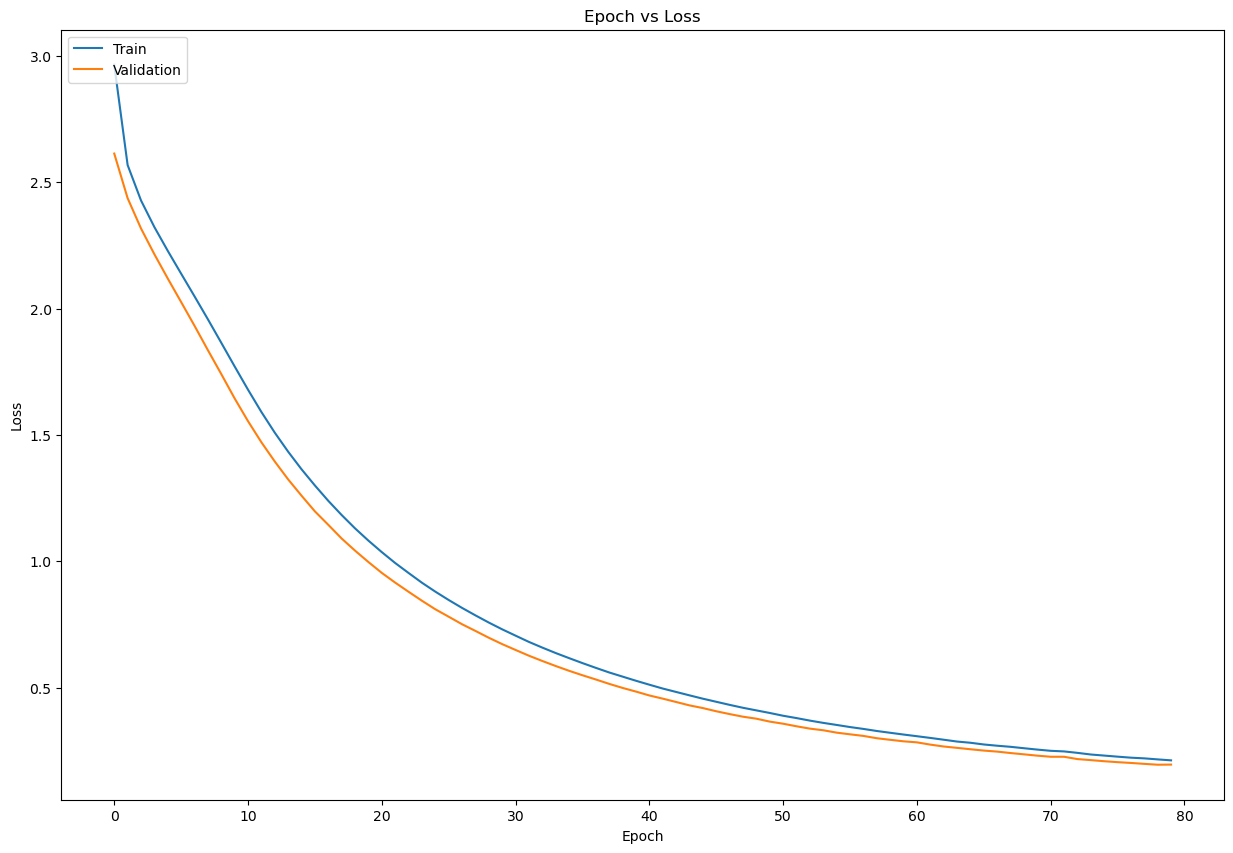

In [22]:
'''Plot Epoch vs Loss'''
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Validation'],loc='upper left')
plt.show()

In [ ]:
import joblib
joblib.dump(model,'model.pkl')

In [36]:

'''Function to predict the output 
input_sentence=input dataset
samples=array takes sample indexes if op is custom,if random it uses first index to
create random numbers,if round it uses first index to create first text of a series 
text generations.
iter=int-number of iterations for round
op='string',if random produces seris of texts for given iter,if custom then 
generates reply for given text,if random generaes random texts of given length
'''
def predict(input_sentence,samples,iter=5,op='random'):
    inputs=input_sentence['encoder_input'].values
    'genrates initial inputs'
    if op=='random':
        random_numbers=np.random.choice(len(inputs),samples[0],replace=False)
        inputs=[inputs[i] for i in random_numbers]
        iter=len(inputs)
    elif op=='custom':
        inputs=[inputs[i] for i in samples]
        iter=len(inputs)
    else:
        inputs=[inputs[i] for i in samples]
        
    targetArray=[] 
    target=inputs[0]
    speaker=['A: ','B: ']
    '''for each input/iteration in case round'''
    for j in range(iter):
        
        if op=='round':
            inp=target
            print(speaker[j%2],inp)
        else:
            inp=inputs[j]
            print('A: ',inp)
        j=j+1
        '''tokenize,pad and initilize initial state for input'''
        sequence=encoder_input_tokenizer.texts_to_sequences([inp])
        sequence=tf.keras.preprocessing.sequence.pad_sequences(sequence,maxlen=max_input_len,
                                                     padding='post',
                                                    truncating='post'
                                                          )

        states=model.layers[0].initialize_states(1)
        encoder_output,lstm_h,lstm_C=model.layers[0](sequence,states)
        decoder_input=np.zeros((1,1))
        decoder_input[0,0]=decoder_input_tokenizer.word_index['<start>']
        target=''
        '''Generate output  for max output length times'''
        for i in range(max_sentencelen):
            decoder_output,lstm_h,lstm_C,attention_weights,context_vector =model.layers[1].one_step_decoder(decoder_input,encoder_output,lstm_h,lstm_C)
            decoder_input[0,0]=np.argmax(decoder_output)
            if decoder_input_tokenizer.index_word[decoder_input[0,0]]=='<end>':
                targetArray.append(target)
                break
            else:
                target=target+" "+decoder_input_tokenizer.index_word[decoder_input[0,0]]
        if op!='round':
            print('B :',target)
    return targetArray,inputs

In [42]:
'''Generate series of texts by passing 1 text'''
predicted,inputs=predict(train,[5804],op='round',iter=17)

A:  Wait a minute.  How do you feel this morning?
B:   Excuse me
A:   No, he was just a private conversation. What do you want to do about it?
B:   We've done nothing yet. This is a very difficult decision, Henry.
A:   Yes.
B:   Do you like the idea of all?
A:   No.
B:   You don't want to get hurt, do you? Okay. Be place where your mother is coming up like this.
A:   Sure, I understand. I just want to be with you.
B:   You don't have to get yourself and open that case.
A:   See, that's it I don't know anything about you.
B:   The game's over. You scared me.
A:   Now you make it your office.
B:   I'll find him.
A:   What are you going to do?
B:   I don't know. Maybe he could help commit me on the map.
A:   We haven't been able to get him in the same day.


In [65]:
'''Generate reply for some selected input and calcualate BLEU score'''
predicted,inputs=predict(train,test_index,custom=True,round=False)
print('\nBLEU score for random texts predicted is:',get_bleu(ref,predicted))

A:  You never wanted to go out with 'me, did you?
B:  I was?
A:  Would you mind getting me a drink, Cameron?
B:  Great
A:  The hell is that?  What kind of 'guy just picks up a girl and carries her away while you're talking to her?
B:  Extremely unfortunate maneuver
A:  Can we go now?
B:  Yes.

BLEU score for random texts predicted is: 0.9602241038134286


<p style="background-color:DodgerBlue;color:White;font-size:140%;">4.3 GPT finetuned</p> 

In [5]:
'''load and preprocess the dataframe'''
df=corpus.get_utterances_dataframe()
df=df[['conversation_id','text']]
df=df[:100000]

user_ids=[]
count=Counter(list(df['conversation_id']))
count_keys=count.keys()
for i in tqdm(count_keys):
    for j in range(count[i]):
        if j%2==0:
            user_ids.append('A: ')
        else:
            user_ids.append('B: ')
            
df['text']=df.text.apply(lambda x:re.sub("[\<\(\[].*?[\)\>\]]",'',x))
df['text']=df['text'].apply(lambda x:x+' <EOL>')
df['text']=user_ids+df['text']


combined_data='\n'.join(list(df['text']))
with open('train.txt','w') as train:
    train.write(combined_data)

100%|██████████| 27430/27430 [00:00<00:00, 715906.53it/s]


In [ ]:
!pip install gpt_2_simple

In [7]:
'''download GPT model with 124M params and finetune the dataset'''
import gpt_2_simple as gpt2
import tensorflow as tf
gpt2.download_gpt2(model_name='124M')
sess = gpt2.start_tf_sess()
gpt2.finetune(sess,dataset='/kaggle/working/train.txt'
             ,model_name='124M'
             ,steps=200
             ,print_every=200
             ,sample_every=100,
              restore_from='fresh'
              
             )

Fetching checkpoint: 1.05Mit [00:00, 363Mit/s]                                                      
Fetching encoder.json: 1.05Mit [00:01, 627kit/s]                                                    
Fetching hparams.json: 1.05Mit [00:00, 384Mit/s]                                                    
Fetching model.ckpt.data-00000-of-00001: 498Mit [01:17, 6.44Mit/s]                                  
Fetching model.ckpt.index: 1.05Mit [00:00, 479Mit/s]                                                
Fetching model.ckpt.meta: 1.05Mit [00:01, 966kit/s]                                                 
Fetching vocab.bpe: 1.05Mit [00:01, 937kit/s]                                                       


Loading checkpoint models/124M/model.ckpt
Loading dataset...


100%|██████████| 1/1 [00:10<00:00, 10.04s/it]


dataset has 2144413 tokens
Training...
======== SAMPLE 1 ========
:
A: You sure... It works. <EOL>
B: So what? <EOL>
A: Yeah... I'm... <EOL>
B: Did you ever say, "Okay, we can't get it again until you make us a promise" again? <EOL>
A: Oh, it's a great idea. If you can get the people to forgive this, we can make some peace. <EOL>
A: If it's good for you, I'll try to make it better. We're coming with lots of work this week.  You look a little nervous right now. <EOL>
B: What do you mean I don't feel any differently? <EOL>
A: You were supposed to try and get the other guys to forgive these cases. <EOL>
B: I thought you said you were going to try and get things done. <EOL>
A: You've been a couple of days without seeing me on Sunday as well... <EOL>
B: Why? Are you having a lot of problems? <EOL>
A: It's fine... I'm sure you've all figured out your problems. <EOL>
B: You still haven't gotten the paperwork? <EOL>
A: We've been in contact with the Attorney's Office... <EOL>
B: You'd have to 

In [8]:
'''generate texts for some inputs'''
test_index=['L695','L580','L584','L413318']
input_data=[]
target_array=[]
for i in test_index:
    inp=df[df.index==i].values[0][1]
    input_data.append(inp.split(': ')[1].rstrip(' <EOL>'))
    print('A:'+inp.split(':')[1].rstrip(' <EOL>'))
    inputs=gpt2.generate(sess,prefix=inp,temperature=0.7,
                         return_as_list=True,
                  include_prefix=False,nsamples=1, batch_size=1,
                  seed=42
                 )
    inputs=inputs[0].split('\n')   
    out=inputs[1]
    target_array.append(out.split(': ')[1].rstrip(' <EOL>'))
    print('B:'+out.split(':')[1].rstrip(' <EOL>'))

A: You never wanted to go out with 'me, did you?
B: You don't know me either.
A: Would you mind getting me a drink, Cameron?
B: Not really, but I like the idea of it. You know, like a little granola bar.
A: The hell is that?  What kind of 'guy just picks up a girl and carries her away while you're talking to her?
B: Not really, man.
A: Can we go now?
B: Not really, but I like the idea of it.


In [15]:
'''Generate reply for some selected input and calcualate BLEU score'''
print('\nBLEU score for random texts predicted is:',get_bleu(ref,target_array))


BLEU score for random texts predicted is: 0.7126467352147094


<p style="background-color:DodgerBlue;color:White;font-size:140%;">4.4 Markov chain using Markovify</p> 

In [6]:
'''load and preprocess the dataframe'''
df=corpus.get_utterances_dataframe()
df=df[['conversation_id','text']]
df=df[:100000]
df['text']=df.text.apply(lambda x:re.sub("[\<\(\[].*?[\)\>\]]",'',x))
combined_data=''.join(list(df['text']))

In [47]:
'''fit the model and generate the text'''
generator=markovify.Text(combined_data,state_size=3,retain_original=False)
name=['A:','B:']
target=[]
for i in range(8):
    sentence=generator.make_sentence(tries=50)
    target.append(sentence)
    print(str(name[i%2]),sentence)

A: Other than her, there's no one out there.Go for it.
B: I don't know.
A: About the business Childs ran?He said he worked there --Yeah.
B: I didn't...If I look weak now, it's over.My friends have a country house we can use liquid nitrogen to keep the newspapers away from him.But it's a great story.
A: You were sent here and you know it!
B: I need your help.
A: I vetted the source, Marty.
B: It won't be long before they commit them.


In [48]:
'''Generate reply for some selected input and calcualate BLEU score'''
print('\nBLEU score for random texts predicted is:',get_bleu(ref,target))


BLEU score for random texts predicted is: 0.8719586172718907


<p style="color:Green;font-size:150%;">5. 
Results</p>

In [49]:
from prettytable import PrettyTable 
table=PrettyTable()
table.field_names=(["Model","BLEU"])
table.add_row(["GPT fine_tuned","0.7126"])
table.add_row(["RNN/base_line","0.8137"])
table.add_row(["Markov chain","0.8719"])
table.add_row(["RNN with attention","0.9602"])

print(table)

+--------------------+--------+
|       Model        |  BLEU  |
+--------------------+--------+
|   GPT fine_tuned   | 0.7126 |
|   RNN/base_line    | 0.8137 |
|    Markov chain    | 0.8719 |
| RNN with attention | 0.9602 |
+--------------------+--------+


**Observation & conclusion/best model**

From the generated conversation for the best model,

* Model fails to generate coherent and meaningful conversation.

* It lacks logical progression,there are grammatical and syntax errors.

* Though it lacks many things ,from the generated sample we can loosely conclude that the conversation is about the two people talking about a case/work that's need to be handled in the future.

* Increasing training data/increasing input and output length may improve the issue.


<p style="color:Green;font-size:150%;">6. 
References</p>

* https://www.analyticsvidhya.com/blog/2018/03/text-generation-using-python-nlp/
* https://www.kaggle.com/code/shivamb/beginners-guide-to-text-generation-using-lstms
* https://hyunjoonlee70.github.io/Blog_Post_3/
* https://towardsdatascience.com/text-generation-with-markov-chains-an-introduction-to-using-markovify-742e6680dc33
* https://machinelearningmastery.com/calculate-bleu-score-for-text-python/
* https://medium.com/@rohansawant7978/grammatical-error-correction-using-deep-learning-ad53044c0977
* https://stackoverflow.com/questions/56415280/fine-tune-gpt-2-text-prediction-for-conversational-ai
* https://github.com/tensorflow/tensorflow/issues/31312

<p style="color:Green;font-size:150%;"> 
Final pipeline</p>

In [34]:
'''We can add the model inside of function,but for each call we need to load
the model and that's an unnecessary overhead'''
# models=joblib.load('model.pkl')

def predict(inputs,iter=1,models=model):
    'load model and tokenizers'
    encoder_input_tokenizer=joblib.load('encoder_input_tokenizer.pkl')
    decoder_input_tokenizer=joblib.load('decoder_input_tokenizer.pkl')
    max_sentencelen=22
    max_input_len=105
    targetArray=[] 
    target=inputs
    speaker=['A: ','B: ']
    
    '''for each iteration'''
    for j in range(iter):
        
        inputs=target
        print(speaker[j%2],inputs)
        j=j+1
        '''tokenize,pad and initilize initial state for input'''
        
        sequence=encoder_input_tokenizer.texts_to_sequences([inputs])
        sequence=tf.keras.preprocessing.sequence.pad_sequences(sequence,maxlen=max_input_len,
                                                     padding='post',
                                                    truncating='post'
                                                          )

        states=models.layers[0].initialize_states(1)
        encoder_output,lstm_h,lstm_C=models.layers[0](sequence,states)
        decoder_input=np.zeros((1,1))
        decoder_input[0,0]=decoder_input_tokenizer.word_index['<start>']
        target=''
        '''Generate output  for max output length times'''
        for i in range(max_sentencelen):
            decoder_output,lstm_h,lstm_C,attention_weights,context_vector =models.layers[1].one_step_decoder(decoder_input,encoder_output,lstm_h,lstm_C)
            decoder_input[0,0]=np.argmax(decoder_output)
            if decoder_input_tokenizer.index_word[decoder_input[0,0]]=='<end>':
                targetArray.append(target)
                break
            else:
                target=target+" "+decoder_input_tokenizer.index_word[decoder_input[0,0]]
    print('A :',target)



In [32]:
predict('Who killed bahubali?',iter=1,models=model)

A:  Who killed bahubali?
B :  We got a long time ago.


In [35]:
predict('Hi',iter=10,models=model)

A:  Hi
B:   I was in the laundromat. I saw your car. Thought I'd say hi.
A:   Are you following me?
B:   I'm going to get to work.
A:   Can I call the cops?
B:   Yep.
A:   That's the whole thing. You know if you are a man who aren't gonna call me, right? And by Harry's your boys
B:   That boss is a mile on either way?
A:   Go home, and I won't thank you right now or it's just an option.
B:   How about what? A Phenomenon. A miracle. A new era of family, that was always one of the sting of that stuff
A :  I was the first ones to let you have a chance.


In [29]:
predict('Say something',iter=10,models=model)

A:  Say something
B:   This the time, boss. For the way, I got sick and tired it is.
A:   But you didn't think about a lot of garbage? I'd like you to know me and if you could choose many of
B:   Well, I saw you from my old friend of a while so many years ago... I just think somethin's happened.
A:   What for?
B:   You never gave me a lift if you didn't get a towel?
A:   See I'm tellin' me why you're not
B:   Nothing to get me outta ya rehearsal.
A:   Uh-uh. What are you doing?
B:   No, we won't.
B :  You go on the beach with your office and stuff.
